In [2]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import networkit as nk
from tqdm import tqdm
import networkx as nx

from benji_girgs import generation, utils, plotting
import geopandas as gpd


from geopy import distance

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
fn = './flightlist_20190601_20190630_processed.pkl'
df = pd.read_pickle(fn)

In [4]:
# airports = list(np.union1d(df.origin.unique(), df.destination.unique()))
airports = list(np.load('airports_list.npy'))
len(airports)

10317

In [5]:
adf = pd.read_csv('./airport-codes_csv.csv')

adf_mini = adf.set_index('ident')
adf_mini = adf_mini.loc[airports]

# reversed s.t. latitude then longitude
adf_mini['coordinates'] = adf_mini.coordinates.apply(lambda x: tuple(reversed([float(y) for y in x.split(', ')])))

adf_mini['lat'] = adf_mini['coordinates'].apply(lambda x: x[0])
adf_mini['long'] = adf_mini['coordinates'].apply(lambda x: x[1])


In [6]:
dists = pd.read_csv('airport_distances3.csv.gz')

dists = dists.iloc[:, 1:]
dists = dists.set_index('ident')

dists_np = dists.to_numpy()

a, b = adf_mini.loc['00AK'].coordinates, adf_mini.loc['00AZ'].coordinates
a, b
distance.distance(a, b)

((59.94919968, -151.695999146), (34.305599212646484, -112.16500091552734))

Distance(4031.3139530844023)

In [7]:

g = nk.Graph(len(airports), weighted=True)
print(g.isWeighted())
pair_counts = df.groupby(['airport_pair']).aircraft_uid.count()
thresh = 1
for pair, count in tqdm(pair_counts.items()):
    u, v = tuple(pair)
    u_id, v_id = airports.index(u), airports.index(v)
    _ = g.addEdge(u_id, v_id, w=count)
    

    
weight_thresh = 1
gthresh = nk.Graph(len(airports))
for u, v, weight in tqdm(g.iterEdgesWeights()):
    if weight >= weight_thresh:
        _ = gthresh.addEdge(u, v)

True


130704it [00:11, 11507.31it/s]
130704it [00:00, 3182691.87it/s]


In [12]:
sub_indices = np.random.choice(dists_np.shape[0], 4000)
dists_np2 = dists_np[sub_indices][:, sub_indices]
gthresh2 = utils.quick_subgraph(gthresh, sub_indices)

In [33]:
import imp
import benji_girgs
imp.reload(benji_girgs)
imp.reload(benji_girgs.utils)
from benji_girgs import utils

<module 'benji_girgs' from '/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/__init__.py'>

<module 'benji_girgs.utils' from '/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/utils.py'>

In [14]:
nk.overview(gthresh2)

Network Properties:
nodes, edges			4000, 13873
directed?			False
weighted?			False
isolated nodes			1241
self-loops			0
density				0.001735
clustering coefficient		0.212830
min/max/avg degree		0, 298, 6.936500
degree assortativity		-0.008995
number of connected components	1258
size of largest component	2726 (68.15 %)


In [16]:
ind =  utils.get_largest_component(gthresh2)
foo = utils.quick_subgraph(gthresh2, ind)

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_21775/253836951.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.linalg.adjacency_matrix(gnx).todense()


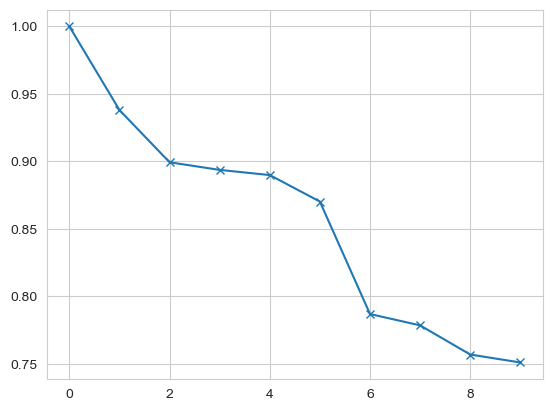

In [17]:
gnx = nk.nxadapter.nk2nx(foo)

A = nx.linalg.adjacency_matrix(gnx).todense()

D = np.array([x[1] for x in (gnx.degree)])
D_h = D**(0.5)
D_hi = D**(-0.5)

M = np.diag(1/D) @ A
M = 0.5 * M + 0.5 * np.eye(M.shape[0])
# S = np.diag(D_hi) @ A @ np.diag(D_hi)
S = np.diag(D_h) @ M @ np.diag(D_hi)

w, V = np.linalg.eigh(S)

# S = V @ np.diag(w) @ V.T
# M = D^{-1/2} @ S @ D^{1/2} 
# = D^{-1/2} @ V @ np.diag(w) @ V.T @ D^{1/2}
# = Phi @ np.diag(w) @ Psi.T
# Phi = D^{-1/2} @ V
# Psi = D^{1/2} @ V


Phi = np.diag(D_hi) @ V
Psi = np.diag(D_h) @ V

n = Phi.shape[0]

def diff_map(i, t):
    # n = 5, so 0, 1, 2, 3, 4, we want to get 3, 2, 1, 0
    # so 5-2 -> -1, -1
    return np.array([Phi[i, j] for j in range(n-2, -1, -1)]) * (np.flip(w)[1:]**t)

plt.plot((np.flip(w)**5)[:10], marker='x')

# sorted(w)

/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/utils.py:656: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.linalg.adjacency_matrix(gnx).todense()


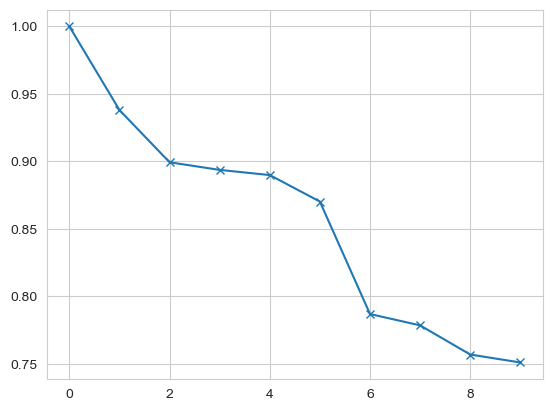

In [19]:
w, Phi, Psi, diff_map = utils.get_diffmap(foo)
plt.plot((w**5)[:10], marker='x')


In [43]:
import benji_src.benji_girgs.fitting


n = foo.numberOfNodes()
tau=2.103
alpha=1.3
const=1.0
d=5
girg_gen_func = lambda const : generation.generate_GIRG_nk(n, d, tau, alpha, const, points_type=generation.PointsCube)[0]
gcf = benji_src.benji_girgs.fitting.GirgConstFitter(utils.avg_degree(foo), girg_gen_func)


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/generation.py:155: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


In [44]:
gcf.verbose=True

In [45]:
gcf.step_n(30)

mu:298.42 -> mu2:247.86; overshoot: False, scale:0.429, const: 0.700
mu:247.86 -> mu2:186.69; overshoot: False, scale:0.612, const: 0.400
mu:186.69 -> mu2:111.24; overshoot: False, scale:0.875, const: 0.155
mu:111.24 -> mu2:37.49; overshoot: False, scale:0.900, const: 0.019
mu:37.49 -> mu2:12.28; overshoot: False, scale:0.900, const: 0.002
mu:12.28 -> mu2:2.87; overshoot: True, scale:0.630, const: 0.000
mu:2.87 -> mu2:4.70; overshoot: False, scale:0.900, const: 0.001
mu:4.70 -> mu2:17.58; overshoot: True, scale:0.630, const: 0.005
mu:17.58 -> mu2:13.51; overshoot: False, scale:0.900, const: 0.002
mu:13.51 -> mu2:2.97; overshoot: True, scale:0.630, const: 0.000
mu:2.97 -> mu2:4.34; overshoot: False, scale:0.900, const: 0.001
mu:4.34 -> mu2:18.66; overshoot: True, scale:0.630, const: 0.005
mu:18.66 -> mu2:8.25; overshoot: True, scale:0.441, const: 0.002
mu:8.25 -> mu2:15.68; overshoot: True, scale:0.309, const: 0.003
mu:15.68 -> mu2:11.94; overshoot: False, scale:0.441, const: 0.002
mu:1

/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/utils.py:657: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.linalg.adjacency_matrix(gnx).todense()


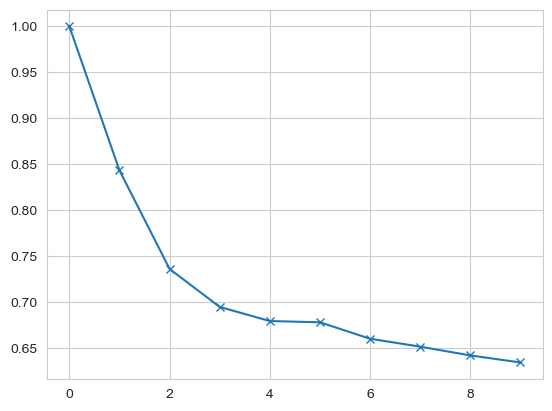

In [46]:
ggirg = gcf.girg_gen_func(gcf.const)
ggirg_connected_ind = utils.get_largest_component(ggirg)
ggirg_connected = utils.quick_subgraph(ggirg, ggirg_connected_ind)
w, Phi, Psi, diff_map = utils.get_diffmap(ggirg_connected)
plt.plot((w**5)[:10], marker='x')

In [47]:
nk.overview(ggirg)

Network Properties:
nodes, edges			2726, 12581
directed?			False
weighted?			False
isolated nodes			85
self-loops			0
density				0.003387
clustering coefficient		0.344258
min/max/avg degree		0, 407, 9.230374
degree assortativity		-0.060869
number of connected components	89
size of largest component	2633 (96.59 %)


In [ ]:
n = ggirg.numberOfNodes()
d = 5
tau = 2.103
alpha = 1.3
const=1.0
def girg_gen_func(alpha, const):
    return generation.generate_GIRG_nk(n, d, tau, alpha, const, points_type=generation.PointsCube)[0]


In [54]:
# import imp
# import benji_girgs
imp.reload(benji_girgs)
imp.reload(benji_girgs.utils)
imp.reload(benji_girgs.fitting)
from benji_girgs import utils, fitting

<module 'benji_girgs' from '/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/__init__.py'>

<module 'benji_girgs.utils' from '/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/utils.py'>

In [57]:
avg_deg = utils.avg_degree(ggirg)
std_gdist = fitting.regularised_std_graph_distance(ggirg)
avg_deg
std_gdist

/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/fitting.py:89: RuntimeWarning: invalid value encountered in cast
  distances = np.array(np.nan_to_num(distances)).astype(np.int64)


9.23037417461482

3.994683967474774

In [58]:
n = ggirg.numberOfNodes()
d = 2
tau = 2.103
alpha = 1.3
const=1.0
def girg_gen_func(alpha, const):
    return generation.generate_GIRG_nk(n, d, tau, alpha, const, points_type=generation.PointsTorus)[0]

gaf = fitting.GirgAlphaFitter(std_gdist, avg_deg, girg_gen_func)


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/generation.py:155: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


In [59]:
gaf.verbose=True
gaf.fit()

/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/generation.py:155: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)


avgdeg: 7.93 -> avgdeg2: 7.91; overshoot: False, scale:0.082, const: 0.008
avgdeg: 7.91 -> avgdeg2: 8.91; overshoot: False, scale:0.090, const: 0.009
avgdeg: 8.91 -> avgdeg2: 11.65; overshoot: True, scale:0.045, const: 0.010
avgdeg: 11.65 -> avgdeg2: 8.80; overshoot: True, scale:0.023, const: 0.009
avgdeg: 8.80 -> avgdeg2: 10.96; overshoot: True, scale:0.011, const: 0.009
avgdeg: 10.96 -> avgdeg2: 8.15; overshoot: True, scale:0.006, const: 0.009
avgdeg: 8.15 -> avgdeg2: 9.24; overshoot: True, scale:0.003, const: 0.009


/Users/benjidayan/GDrive/eth_courses/GIRG/benji_src/benji_girgs/fitting.py:89: RuntimeWarning: invalid value encountered in cast
  distances = np.array(np.nan_to_num(distances)).astype(np.int64)


std_gdist: 6.98 -> std_gdist2: 4.85; overshoot: False, scale:0.330, alpha: 1.210
std_gdist: 4.85 -> std_gdist2: 4.73; overshoot: False, scale:0.363, alpha: 1.141
avgdeg: 8.36 -> avgdeg2: 10.39; overshoot: True, scale:0.003, const: 0.009
avgdeg: 10.39 -> avgdeg2: 10.07; overshoot: False, scale:0.003, const: 0.009
avgdeg: 10.07 -> avgdeg2: 8.15; overshoot: True, scale:0.002, const: 0.009
avgdeg: 8.15 -> avgdeg2: 9.06; overshoot: False, scale:0.002, const: 0.009
std_gdist: 4.73 -> std_gdist2: 4.87; overshoot: False, scale:0.399, alpha: 1.090
avgdeg: 7.05 -> avgdeg2: 9.10; overshoot: False, scale:0.003, const: 0.009
std_gdist: 4.87 -> std_gdist2: 4.61; overshoot: False, scale:0.439, alpha: 1.054
avgdeg: 8.00 -> avgdeg2: 8.98; overshoot: False, scale:0.005, const: 0.009
std_gdist: 4.61 -> std_gdist2: 4.99; overshoot: False, scale:0.483, alpha: 1.030
avgdeg: 7.47 -> avgdeg2: 7.28; overshoot: False, scale:0.009, const: 0.010
avgdeg: 7.28 -> avgdeg2: 8.91; overshoot: False, scale:0.010, const:

KeyboardInterrupt: 

In [60]:
gaf.hist

[(1.3, 6.983843068110852),
 (1.21, 4.852787961574254),
 (1.1407, 4.7326233739861445),
 (1.0896259000000001, 4.870987476888029),
 (1.05383827813, 4.609692397546716),
 (1.0301908912269602, 4.992853993459052),
 (1.0156040715579806, 4.880237289312888),
 (1.0073110021739824, 4.5390377834955284),
 (1.0030368796876095, 4.354124481454337),
 (1.0010839332929067, 4.669850104660748),
 (1.0003171758913445, 4.783555058740308),
 (1.0000703741183343, 5.054540038420905),
 (1.0000101384465252, 5.009207122888811),
 (1.0000010138446525, 4.945919934653209),
 (1.0000001013844653, 4.935017325197552)]